## Entrega: Guido Alvarez

## Descripcion:
Modulador QPSK solo para Pluto

Incluye:
 - Generacion de Señal de datos aleatoria
 - Modulacion QPSK con la posibilidad de usar (rect, rc, rcc)
 - Diagrama de ojo señal a transmitir
 - FFT señal a transmitir
 - Diagrama de constelacion
 - Filtro pasa bajos
 - Diagrama de ojo señal recibida
 - Diagrama de constelacion señal recibida
 - FFT señal recibida
 - Muestreo y umbralizado

Version: 1

## Importamos librerias

In [1]:
#!pip install scikit-dsp-comm

In [9]:
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
%matplotlib notebook

## Generamos una señal a transmitir

<IPython.core.display.Javascript object>


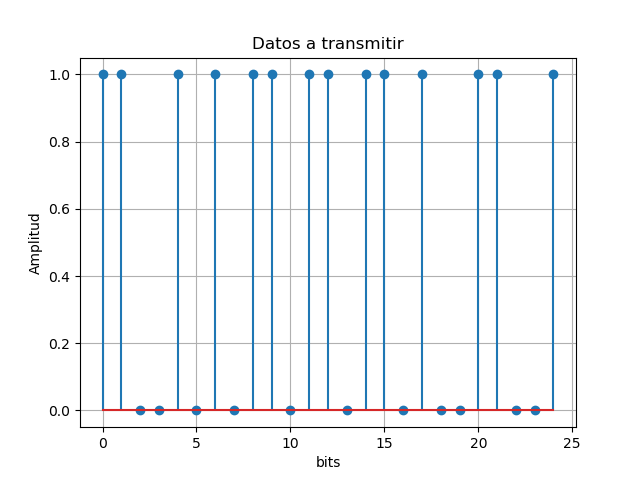

In [10]:
NroBits = 1000     # Numero de bits a transmitir
fs = 521e3         # Frecuencia de muestreo [Hz], observar que es la mínima que le podemos pasar a la Pluto.
ts = 1/fs          # Periodo de muestreo [sec]
Tbit = 0.000521    # Tiempo del bit [sec]
Ns = int(fs*Tbit)  # Muestras por bit de dato, cuantas veces repetir el bit en un simbolo

TxData = np.random.randint(2,size=NroBits)

plt.figure()
plt.stem(TxData[0:25], use_line_collection=True)
plt.title("Datos a transmitir")
plt.xlabel("bits")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

## Generamos la señal QPSK

<IPython.core.display.Javascript object>


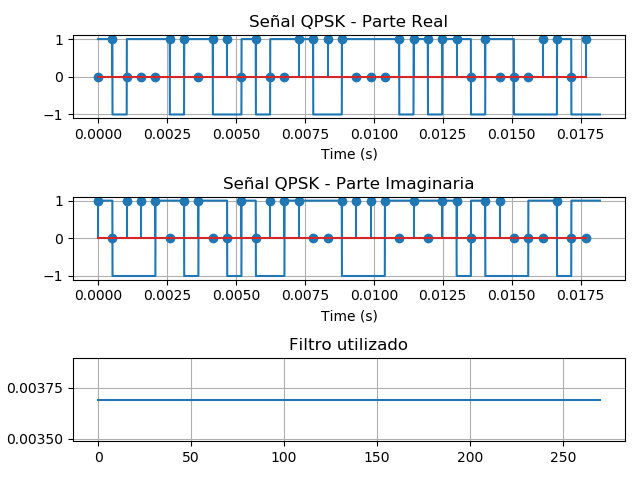

In [11]:
# Parametros para la QPSK
Pulse = 'rect'  # Tipo de filtro a utilizar [rect, rc, rcc]
Alpha = 1     # Parametro alpha del filtro, es el exceso de BW en el pulso conformador.


# Generacion de la QPSK
TxdataI = TxData[0::2] #Los bits pares para el canal I
TxdataQ = TxData[1::2] #Los bits impares para el canal Q
Signal_NRZ_I, Pulse_shape_I = ss.NRZ_bits2(TxdataI,Ns,pulse=Pulse,alpha=Alpha) #Una señal NRZ para el canal I
Signal_NRZ_Q, Pulse_shape_Q = ss.NRZ_bits2(TxdataQ,Ns,pulse=Pulse,alpha=Alpha) #Una señal NRZ para el canal Q

Signal_NRZ_IQ = (Signal_NRZ_I + 1j*Signal_NRZ_Q) #Pluto requiere que le pasemos la señal ya compleja
t = np.arange(len(Signal_NRZ_IQ)) #Vector de tiempos, solo para graficar.


# Ajuste del retraso generado, solo a fin de poder graficar correctamente
Desfasaje = 1 #12
Aux_TxData = np.zeros(Desfasaje,dtype=int).tolist() + TxData.tolist() 

plt.figure()
plt.subplot(311)
plt.plot(ts*t[0:Ns*35], Signal_NRZ_I[0:Ns*35])
plt.stem(ts*t[0:Ns*35:Ns], Aux_TxData[0:70:2], use_line_collection=True)
plt.title("Señal QPSK - Parte Real")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(312)
plt.plot(ts*t[0:Ns*35],Signal_NRZ_Q[0:Ns*35])
plt.stem(ts*t[0:Ns*35:Ns], Aux_TxData[1:70:2], use_line_collection=True)
plt.title("Señal QPSK - Parte Imaginaria")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(313)
plt.plot(Pulse_shape_I)
plt.title("Filtro utilizado")
plt.grid()
plt.tight_layout()
plt.show()

## Diagrama de ojo, señal

<IPython.core.display.Javascript object>


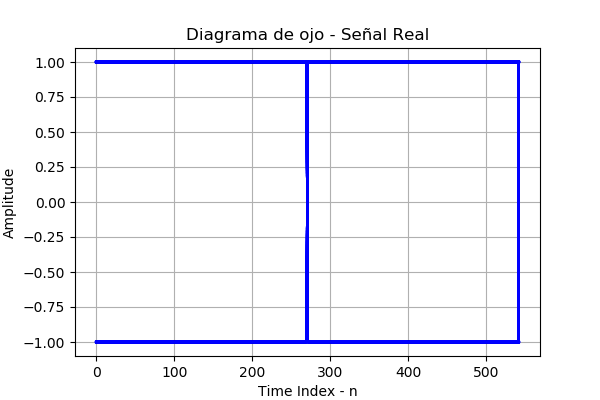

<IPython.core.display.Javascript object>


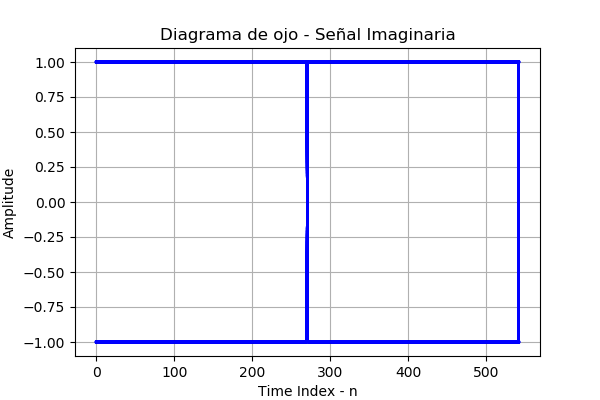

In [12]:
L = Ns*2        
S = 0          
dc.eye_plot(np.real(Signal_NRZ_IQ[Ns*100:Ns*400]),L,S) 
plt.title("Diagrama de ojo - Señal Real")
dc.eye_plot(np.imag(Signal_NRZ_IQ[Ns*100:Ns*400]),L,S) 
plt.title("Diagrama de ojo - Señal Imaginaria")
plt.show()

## FFT, Señal transmitida

<IPython.core.display.Javascript object>


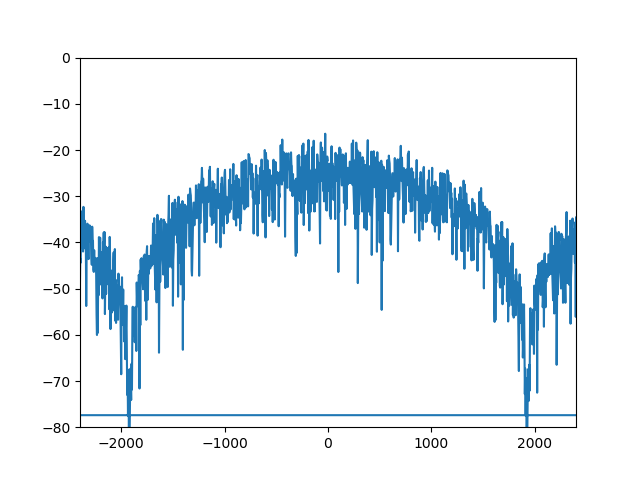

C:\Users\PC-Admin\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [13]:
plt.figure() #Espectro de la señal en banda base.
N = Signal_NRZ_IQ.shape[0]
Y = fft(Signal_NRZ_IQ)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-int(1/Tbit) - int((1/Tbit)*0.25), int(1/Tbit) + int((1/Tbit)*0.25))
plt.ylim(-80,0)
plt.show()

## Diagrama de constelacion

<IPython.core.display.Javascript object>


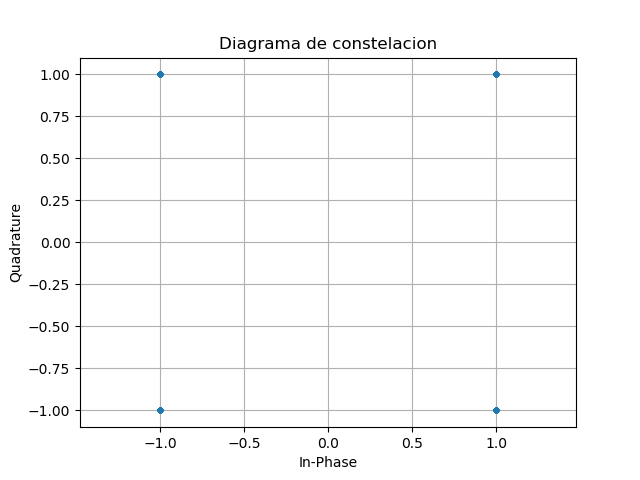

In [14]:
yI,yQ = dc.scatter(Signal_NRZ_IQ,Ns,Ns*6)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.title("Diagrama de constelacion")
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

## Configuro la Pluto y transmito la señal
La modulacion de la portadora se realiza en la pluto

In [8]:
del(sdr)

NameError: name 'sdr' is not defined

In [15]:
import adi

sdr = adi.Pluto()

sdr.rx_lo = int(1e9) # [Hz] #Seteamos la señal de rececpcion igual que transmisión.
sdr.rx_buffer_size = len(Signal_NRZ_IQ) #El buffer igual a toda la señal a transmitir

sdr.tx_destroy_buffer()
sdr.tx_lo = int(1e9) # [Hz] #La frecuencia debe ser alta en la Pluto
sdr.tx_cyclic_buffer = True #Para que repita la señal una y otra vez.
sdr.tx_hardwaregain_chan0 = -10
sdr.gain_control_mode_cahn0 = "slow_attack"
sdr.sample_rate = fs # [Hz]

fs_pluto = int(sdr.sample_rate)
print('fs =',fs_pluto)

# Send data
sdr.tx(Signal_NRZ_IQ*2**14)

fs = 520999


## Recibo la señal

(135500,)


<IPython.core.display.Javascript object>


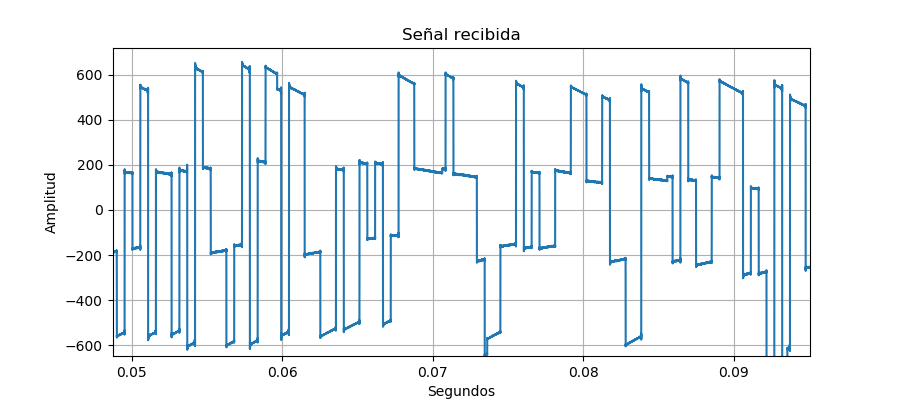

In [26]:
signal_rx = sdr.rx() #Recibo toda la señal, solo muestro la parte real.
print(signal_rx.shape)
plt.figure(figsize=(9,4))
plt.plot(t*ts, np.real(signal_rx))
plt.title("Señal recibida")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
#plt.xlim(0,0.01)
plt.grid()

## FFT, señal Recibida

<IPython.core.display.Javascript object>


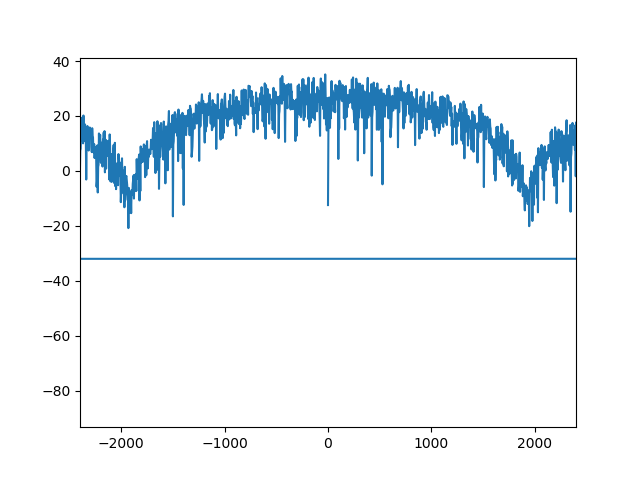

In [27]:
plt.figure() #Vemos todo el espectro de la señal recibida.
N = signal_rx.shape[0]
Y = fft(signal_rx)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-int(1/Tbit) - int((1/Tbit)*0.25), int(1/Tbit) + int((1/Tbit)*0.25))
#plt.ylim(-90,0)
plt.show()

## Demodulacion, Filtro pasa bajos


<IPython.core.display.Javascript object>


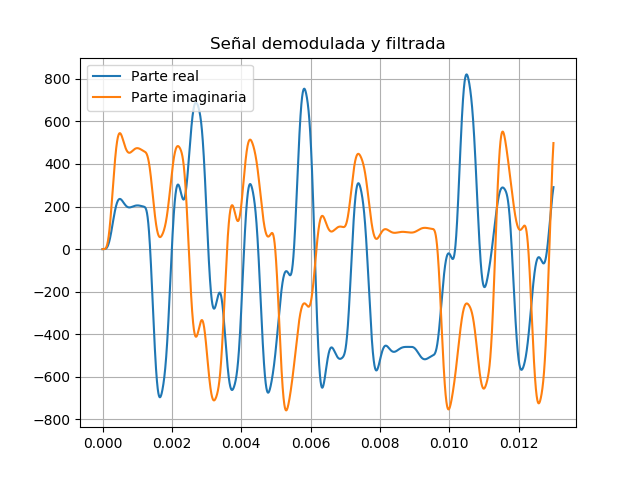

In [28]:
# Filtro pasa bajos
nyq = fs/2
low = 2000 / nyq
order = 5
b, a = butter(order, low, btype='low') 
y = lfilter(b, a, signal_rx)

plt.figure()
plt.plot(ts*t[0:Ns*25], np.real(y[0:Ns*25]),ts*t[0:Ns*25], np.imag(y[0:Ns*25]))
plt.grid()
plt.title("Señal demodulada y filtrada")
plt.legend(('Parte real', 'Parte imaginaria'))

## Diagrama de ojo, señal demodulada

<IPython.core.display.Javascript object>


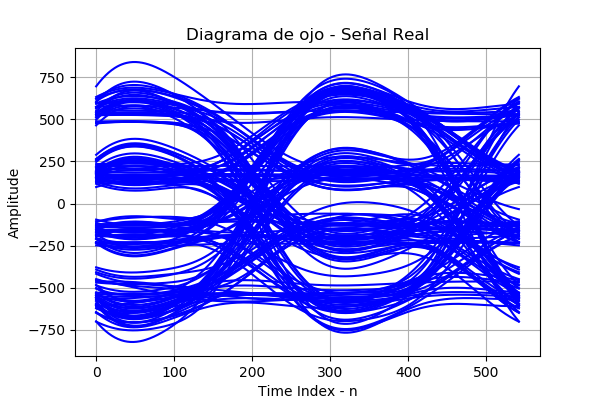

<IPython.core.display.Javascript object>


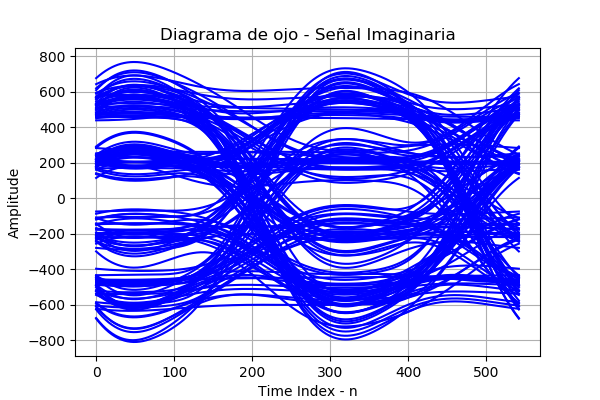

In [29]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(np.real(y[Ns*100:Ns*400]),L,S)
plt.title("Diagrama de ojo - Señal Real")
dc.eye_plot(np.imag(y[Ns*100:Ns*400]),L,S)
plt.title("Diagrama de ojo - Señal Imaginaria")
plt.show()

## FFT, señal demodulada

<IPython.core.display.Javascript object>


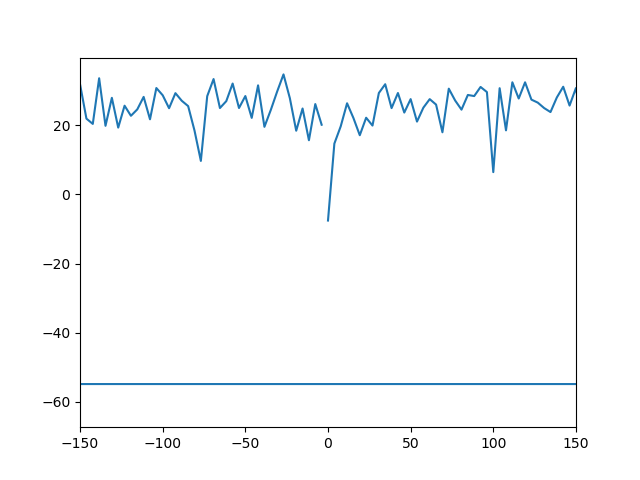

In [23]:
plt.figure()
N = y.shape[0]
Y = fft(y)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-150,150)
#plt.ylim(-80,0)
plt.show()

## Diagrama de constelacion

<IPython.core.display.Javascript object>


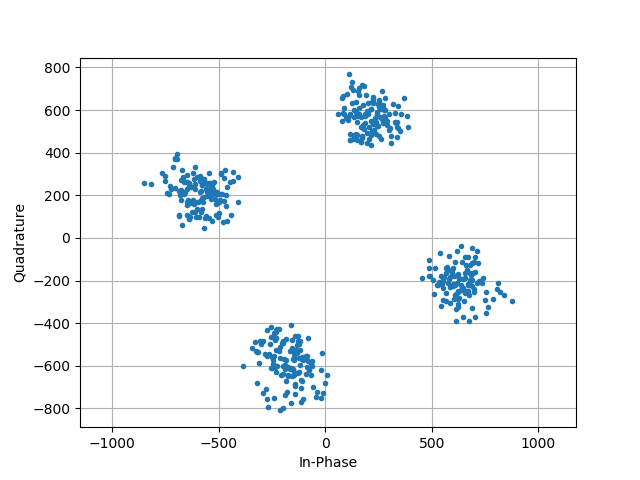

In [30]:
yI,yQ = dc.scatter(y,Ns,(Ns*6)+55)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

## Muestreo y umbralizado

<IPython.core.display.Javascript object>


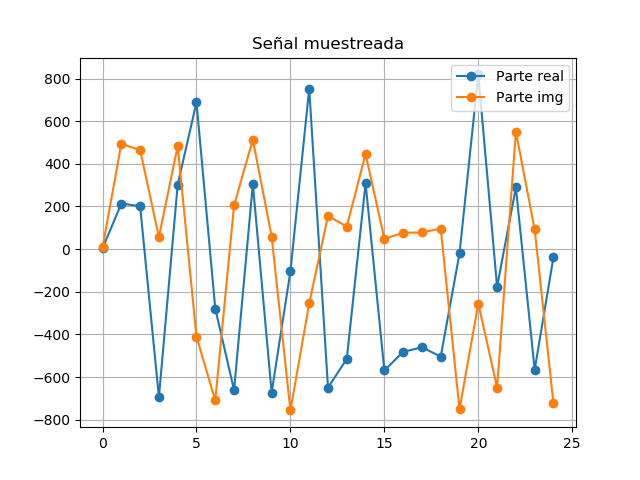

Los bits recibidos no son iguales a los transmitidos
BER:  0.4924924924924925


In [31]:
# Centro del diagrama de ojo:
Eye_center = 55
ys_I = np.real(y[Eye_center::Ns])
ys_Q = np.imag(y[Eye_center::Ns]) 


plt.figure()
plt.plot(ys_I[0:25], '-o',ys_Q[0:25], '-o')
plt.grid()
plt.title("Señal muestreada")
plt.legend(('Parte real','Parte img'))

# Umbralizado, se hace para convertir la señal NRZ a 0s y 1s
RxData_I = 1*(ys_I > 0)
RxData_Q = 1*(ys_Q > 0)
RxData = np.zeros(len(RxData_I)+len(RxData_Q),dtype=int)
RxData[0::2] = RxData_I
RxData[1::2] = RxData_Q


# Verificacion de bits recibidos
if ((TxData[:-Desfasaje]==RxData[Desfasaje:]).all()):
    print("Todos los bits recibidos son iguales a los transmitidos")
else:
    print("Los bits recibidos no son iguales a los transmitidos")
    
# Calculo del BER
ber = np.sum(np.abs(RxData[Desfasaje:] - TxData[:-Desfasaje]))/len(TxData[:-Desfasaje])
print("BER: ",ber)

## Pregunta...
#### ¿Cuál es el efecto de modificar la fs (frecuencia de muestreo) en la conformación de los bits, manteniendo constante el número de bits (NroBits) y el tiempo de bit (Tbit)?. ¿Y en el desempeño de la Pluto?